# Multiclass Logistic Regression from Scratch

If you've made it through our tutorial on linear regression from scratch, then you're past the hardest part. You already know how to load and manipulate data, build computation graphs on the fly, and take derivatives. You also know how to define a loss function, and a model and how to write your own optimizer. 

Nearly all neural networks that we'll build in the real world consist of these same fundamental parts. The main differences will be the type and scale of the data, and the complexity of the models. And every year or two, a new hipter optimizer comes around, but at their core they're all subtle variations of stochastic gradient descent.

So let's work on a more interesting problem now. We're going to classify images of handwritten digits like these:
![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/mnist.png). We're going to implemment a model called multiclass logistic regression. It's also commonly called softmax regression

To start, let's import our bag of libraries.

In [91]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
import numpy as np

We'll also ewant to set the compute context for our modeling. Feel free to go ahead and change this to mx.gpu(0) if you're running on an appropriately endowed machine.

In [111]:
ctx = mx.cpu()

## The MNIST Dataset

This time we're going to work with real data, each a 28 by 28 centrally cropped black & white photograph of handwritten digit. Our task will be come up with a model that can associate each image with the digit (0-9) that it depicts.

To start, we'll use MXNet's utility for grabbing a copy of this dataset.

In [92]:
mnist = mx.test_utils.get_mnist()

The retrieved object consists of a Python dictionary with four keys: ``train_data``,  ``train-label``, ``test_data``, and ``test_label``. We can take a look at the format of examples.

In [93]:
image = mnist["train_data"][0]
print(image.shape)

(1, 28, 28)


Note that each image has been formatted as a 3-tuple (channel, height, width). For color images, the channel would have 3 dimensions (red, green and blue). We can also check out the labels.

In [94]:
label = mnist["train_label"][0]
print(label)

5


Machine learning libraries generally expect to find images in (batch, channel, height, width) format. However, most libraries for visualization prefer (height, width, channel). Let's transpose our image into the expected shape.

In [95]:
im = np.tile(image.transpose(1,2,0), (1,1,3))
print(im.shape)

(28, 28, 3)


Now we can visualize our image and make sure that our data and labels line up.

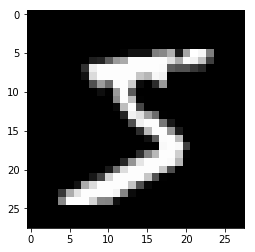

In [96]:
import matplotlib.pyplot as plt
plt.imshow(im)
plt.show()

Ok, that's a beautiful five. 

## Data Iterators

Now let's load these images into data iterator so we don't have to do the heavy lifting. 

In [97]:
batch_size = 64
train_data = mx.io.NDArrayIter(mnist["train_data"], mnist["train_label"], batch_size, shuffle=True)

We're also going to want to load up an iterator with *test* data. After we train on the training dataset we're going to want to test our model on the test data. Otherwise, for all we know, our model could be doing something stupid (or treacherous?) like memorizing the training examples and regurgitating the labels on command.

In [98]:
test_data = mx.io.NDArrayIter(mnist["test_data"], mnist["test_label"], batch_size, shuffle=True)

## Model Parameters

Now we're going to define our model. For this example, we're going to ignore the multimodal structure of our data and just flatten each image into a single 1D vector with 28x28 = 784 components. 

Because our task is multiclass classification, we want to assign a probability to each of the classes P(Y=c|X) given the input X. In order to do this we're going to need one vector of 784 weights for each class, connecting each feature to the corresponding output. Because there are 10 classes, we can collect these weights together in a 784 by 10 matrix.

We'll also want to allocate one offset for each of the outputs. We call these offsets the *bias term* and collect them in the 10-dimensional array ``b``.

In [99]:
W = nd.random_normal(shape=(784,10))
b = nd.random_normal(shape=10)

params = [W, b]

As before, we need to let MXNet know that we'll be expecing gradients corresponding to each of these parameters during training.

In [100]:
for param in params:
    param.attach_grad()

## Multiclass Logistic Regression

In linear regression tutorial, we performed regression, so we had just one output *yhat* and tried to push this value as close as possible to the true target *y*. Here, instead of regression, we are performing *classification*, where we want to assign each input *X* to one of *L* classes. 

The basic modeling idea is that we're going to linearly map our input *X* onto 10 different real valued outputs ``y_linear``. Then before, outputting these values, we'll want to normalize them so that they are non-negative and sum to 1. This normalization allows us to interpret the output yhat as a valid probability distribution.



In [101]:
def softmax(y_linear):
    exp = nd.exp(y_linear)
    partition =nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / partition

In [102]:
sample_y_linear = nd.random_normal(shape=(2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)

[[ 0.47994873  0.07577296  0.12337881  0.06991829  0.0219575   0.07842734
   0.07198865  0.02435546  0.00750023  0.04675202]
 [ 0.08979932  0.03050132  0.04686036  0.25880578  0.01719401  0.04184246
   0.0257007   0.4736675   0.00970429  0.00592434]]
<NDArray 2x10 @cpu(0)>


Let's confirm that indeed all of our rows sum to 1. 

In [103]:
print(nd.sum(sample_yhat, axis=1))

[ 1.          1.00000012]
<NDArray 2 @cpu(0)>


But for small rounding errors, the function works as expected.

### Defining the Model

Now we're ready to define our model

In [104]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat

## The Cross-entropy Loss Function

Before we can start training, we're going to need to define a loss function that makes sense when our prediction is a  probability distribution. 

The relevant loss function here is called cross-entropy and it may be the most common loss function you'll find in all of deep learning. That's because at the moment, classification problems tend to be far more abundant than regression problems. 

The basic idea is that we're going to take a target Y that has been formatted as a one-hot vector, meaning one value corrsponding to the correct label is set to 1 and the others are set to 0, e.g. ``[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]``. 


The basic idea of cross-entropy loss is that we only care about how much probability the prediction assigned to the correct label. In other words, for true label 2, we only care about the component of yhat corrsponding to 2. Cross-entropy attempts to maximize the log-likelihood given to the correct labels.

In [105]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

In [106]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

In [107]:
## Evaluation Metric

In [108]:

def evaluate_accuracy(dataset):
    numerator = 0.
    denominator = 0.
    
    dataset.reset()
    for i, batch in enumerate(dataset):
        with autograd.record():
            data = batch.data[0].as_in_context(ctx).reshape((-1,784))
            label = batch.label[0].as_in_context(ctx)
            label_one_hot = nd.one_hot(label, 10)
            output = net(data)
        
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
#         print(numerator)
#         print(denominator)
    return (numerator / denominator).asscalar()

In [109]:
evaluate_accuracy(test_data)

0.099422768

In [110]:
epochs = 10
moving_loss = 0.

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):
        with autograd.record():
            data = batch.data[0].as_in_context(ctx).reshape((-1,784))
            label = batch.label[0].as_in_context(ctx)
            label_one_hot = nd.one_hot(label, 10)
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
            loss.backward()
        SGD(params, .001)
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(loss.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(loss.asnumpy()[0])
            
#   if i % 100 == 0:
    test_accuracy = evaluate_accuracy(test_data)
    train_accuracy = evaluate_accuracy(train_data)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))    
    

Epoch 0. Loss: 1.36072924294, Train_acc 0.759478, Test_acc 0.77508
Epoch 1. Loss: 0.97883170244, Train_acc 0.81345, Test_acc 0.824841
Epoch 2. Loss: 0.838025440457, Train_acc 0.835671, Test_acc 0.845342
Epoch 3. Loss: 0.753532010029, Train_acc 0.848597, Test_acc 0.854697
Epoch 4. Loss: 0.691739992352, Train_acc 0.85701, Test_acc 0.862958
Epoch 5. Loss: 0.642571576586, Train_acc 0.863423, Test_acc 0.869029
Epoch 6. Loss: 0.60215177382, Train_acc 0.868403, Test_acc 0.872711
Epoch 7. Loss: 0.568401340196, Train_acc 0.872018, Test_acc 0.875697
Epoch 8. Loss: 0.539815085574, Train_acc 0.874967, Test_acc 0.879279
Epoch 9. Loss: 0.515191418905, Train_acc 0.877515, Test_acc 0.883161


## Conclusion

Jeepers. We can get nearly 90% accuracy at this task just by training a linear model for a few seconds! You might reasonably conclude that this problem is too easy to be taken seriously by experts.

But until recently, many papers (Google Scholar says 13,800) were published using results obtained on this data. Even this year, I reviewed a paper whose primary achievment was an (imagined) improvement in performance. While MNIST can be a nice toy dataset for testing new ideas, we don't recommend writing papers with it. 